# Inference example for trained 2D U-Net model on BraTS.
Takes a trained model and performs inference on a few validation examples.

In [1]:
import sys
import platform
import os
print("Python version: {}".format(sys.version))
print("{}".format(platform.platform()))

Python version: 3.10.8 (main, Nov 24 2022, 14:13:03) [GCC 11.2.0]
Linux-5.19.0-051900-generic-x86_64-with-glibc2.35


In [4]:
import settings
enable_OMP_settings = True

if enable_OMP_settings:
    # If hyperthreading is enabled, then use
    os.environ["KMP_AFFINITY"] = "granularity=thread,compact,1,0"

    # If hyperthreading is NOT enabled, then use
    #os.environ["KMP_AFFINITY"] = "granularity=thread,compact"

    os.environ["KMP_BLOCKTIME"] = str(settings.BLOCKTIME)
    os.environ["OMP_NUM_THREADS"] = str(settings.NUM_INTRA_THREADS)
    os.environ["KMP_SETTINGS"] = "0"  # Show the settings at runtime

else:
    os.environ["INTRA_THREADS"] = str(settings.NUM_INTRA_THREADS)
    os.environ["INTER_THREADS"] = str(settings.NUM_INTER_THREADS)

In [5]:
def test_oneDNN():
    import tensorflow as tf

    import os

    def get_mkl_enabled_flag():

        mkl_enabled = False
        major_version = int(tf.__version__.split(".")[0])
        minor_version = int(tf.__version__.split(".")[1])
        if major_version >= 2:
            if minor_version < 5:
                from tensorflow.python import _pywrap_util_port
            elif minor_version >= 9:

                from tensorflow.python.util import _pywrap_util_port
                onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '1'))

            else:
                from tensorflow.python.util import _pywrap_util_port
                onednn_enabled = int(os.environ.get('TF_ENABLE_ONEDNN_OPTS', '0'))
            mkl_enabled = _pywrap_util_port.IsMklEnabled() or (onednn_enabled == 1)
        else:
            mkl_enabled = tf.pywrap_tensorflow.IsMklEnabled()
        return mkl_enabled

    print ("We are using Tensorflow version", tf.__version__)
    print("oneDNN enabled :", get_mkl_enabled_flag())
test_oneDNN()   

2023-01-23 03:14:07.160555: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 03:14:07.322962: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-23 03:14:07.330268: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-23 03:14:07.330284: I tensorflow/stream_executor/cuda/cuda

We are using Tensorflow version 2.10.0
oneDNN enabled : True


2023-01-23 03:14:08.712964: E itex/core/kernels/xpu_kernel.cc:36] XPU-GPU kernel not supported.
2023-01-23 03:14:08.784475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-23 03:14:08.784509: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-23 03:14:08.784541: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (000000000000.jf.intel.com): /proc/driver/nvidia/version does not exist


<b><font size ="5"> Enable Advanced AMP </font>

In [6]:
enable_amp = True
if enable_amp:
    saved_model_dir = "./output/2d_unet_decathlon_bf16"
else:
    saved_model_dir = "./output/2d_unet_decathlon"

In [7]:
# Create output directory for images
png_directory = "inference_examples"
if not os.path.exists(png_directory):
    os.makedirs(png_directory)
    
model_filename = os.path.join(saved_model_dir)

#### Define the DICE coefficient and loss function

The Sørensen–Dice coefficient is a statistic used for comparing the similarity of two samples. Given two sets, X and Y, it is defined as

\begin{equation}
dice = \frac{2|X\cap Y|}{|X|+|Y|}
\end{equation}

In [8]:
import numpy as np

def calc_dice(target, prediction, smooth=0.0001):
    """
    Sorensen Dice coefficient
    """
    prediction = np.round(prediction)

    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

def calc_soft_dice(target, prediction, smooth=0.0001):
    """
    Sorensen (Soft) Dice coefficient - Don't round predictions
    """
    numerator = 2.0 * np.sum(target * prediction) + smooth
    denominator = np.sum(target) + np.sum(prediction) + smooth
    coef = numerator / denominator

    return coef

## Inference Time!

Inferencing in this example can be done in 3 simple steps:
1. Load the data
1. Load the Keras model 
1. Perform a `model.predict` on an input image (or set of images)

#### Step 1 : Load data

In [9]:
data_path = "../Task01_BrainTumour/"

crop_dim=128  # Original resolution (240)
batch_size = 128
seed=816
train_test_split=0.85

In [10]:
from dataloader import DatasetGenerator, get_decathlon_filelist

trainFiles, validateFiles, testFiles = get_decathlon_filelist(data_path=data_path, seed=seed, split=train_test_split)

ds_test = DatasetGenerator(testFiles, 
                           batch_size=batch_size, 
                           crop_dim=[crop_dim, crop_dim], 
                           augment=False, 
                           seed=seed)


******************************
Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Dataset license:      CC-BY-SA 4.0
******************************
Number of training files   = 411
Number of validation files = 36
Number of testing files    = 37


#### Step 2 : Load the model

In [11]:
from model import unet

from tensorflow import keras as K
model = K.models.load_model(saved_model_dir, compile=False, custom_objects=unet().custom_objects)

Data format = channels_last


/home/nazneen/miniconda3/envs/itex-tf/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
2023-01-23 03:14:21.770838: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### Step 3: Perform prediction on some images. 
The prediction results will be saved in the output directory for images, which is defined by the `png_directory` variable.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import time

def plot_results(ds):
    
    plt.figure(figsize=(10,10))

    img, msk = next(ds.ds)

    idx = np.argmax(np.sum(np.sum(msk[:,:,:,0], axis=1), axis=1)) # find the slice with the largest tumor

    plt.subplot(1, 3, 1)
    plt.imshow(img[idx, :, :, 0], cmap="bone", origin="lower")
    plt.title("MRI {}".format(idx), fontsize=20)

    plt.subplot(1, 3, 2)
    plt.imshow(msk[idx, :, :], cmap="bone", origin="lower")
    plt.title("Ground truth", fontsize=20)

    plt.subplot(1, 3, 3)

    print("Index {}: ".format(idx), end="")
    
    # Predict using the TensorFlow model
    start_time = time.time()
    prediction = model.predict(img[[idx]])
    print("Elapsed time = {:.4f} msecs, ".format(1000.0*(time.time()-start_time)), end="")
    
    plt.imshow(prediction[0,:,:,0], cmap="bone", origin="lower")
    dice_coef = calc_dice(msk[idx], prediction)
    print("Dice coefficient = {:.4f}, ".format(dice_coef), end="")
    plt.title("Prediction\nDice = {:.4f}".format(dice_coef), fontsize=20)


Index 72: 

2023-01-23 03:14:29.484585: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:29.490986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:29.502765: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:29.644982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


1/1 [==============================] - 0s 356ms/step
Elapsed time = 511.3862 msecs, Dice coefficient = 0.7162, 

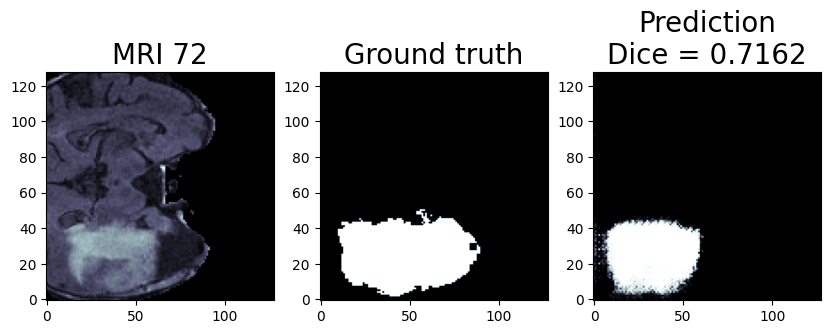

In [13]:
plot_results(ds_test)

1/1 [==============================] - 0s 47ms/step
Elapsed time = 78.6831 msecs, Dice coefficient = 0.6429, 

2023-01-23 03:14:37.391181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:37.397441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:37.406973: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


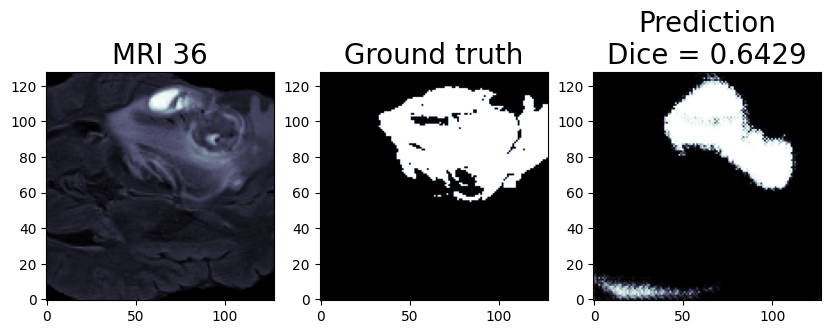

In [14]:
plot_results(ds_test)

1/1 [==============================] - 0s 47ms/step
Elapsed time = 81.6967 msecs, Dice coefficient = 0.6839, 

2023-01-23 03:14:45.936889: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:45.943117: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:45.952707: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


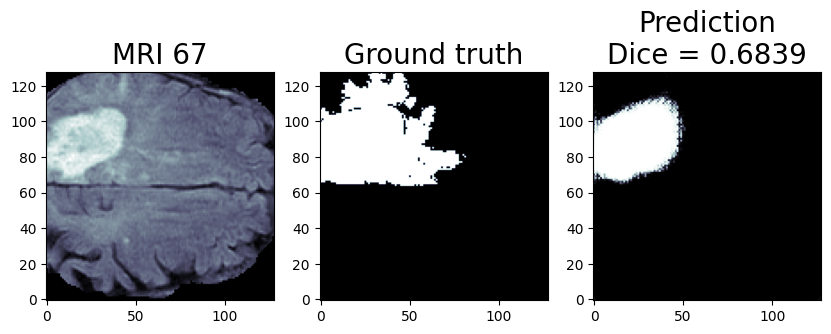

In [16]:
plot_results(ds_test)

1/1 [==============================] - 0s 34ms/step
Elapsed time = 66.3228 msecs, Dice coefficient = 0.8328, 

2023-01-23 03:14:51.563804: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:51.570313: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:51.579801: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


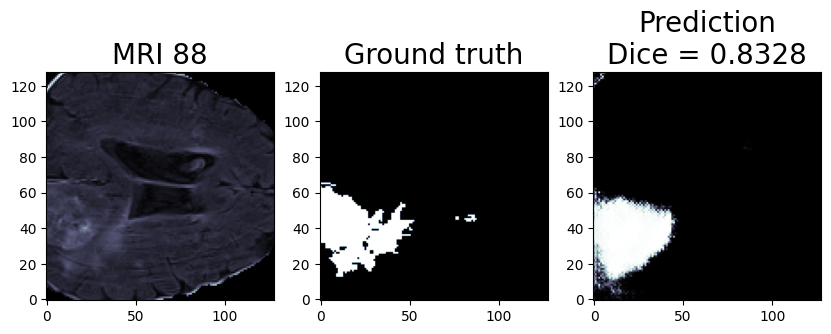

In [17]:
plot_results(ds_test)

1/1 [==============================] - 0s 34ms/step
Elapsed time = 65.5036 msecs, Dice coefficient = 0.8175, 

2023-01-23 03:14:56.868643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:56.874682: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:14:56.884170: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


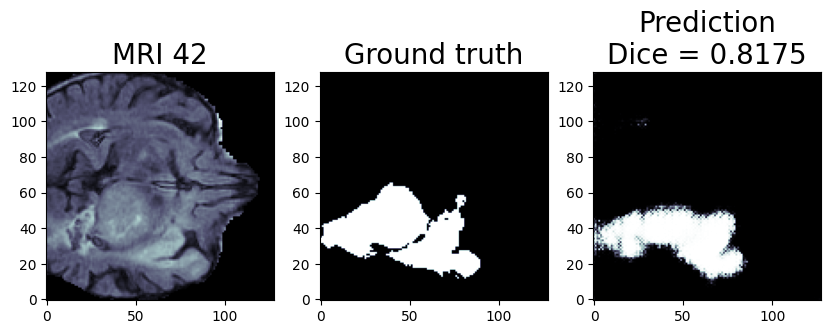

In [18]:
plot_results(ds_test)

1/1 [==============================] - 0s 36ms/step
Elapsed time = 69.1321 msecs, Dice coefficient = 0.8282, 

2023-01-23 03:15:01.470406: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:15:01.476544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:15:01.486011: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


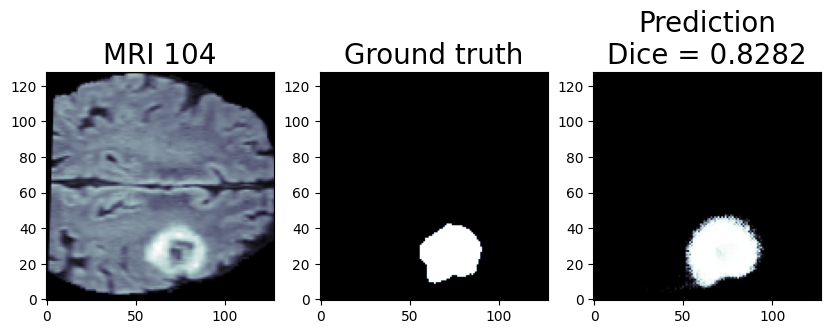

In [19]:
plot_results(ds_test)

1/1 [==============================] - 0s 36ms/step
Elapsed time = 67.1408 msecs, Dice coefficient = 0.7177, 

2023-01-23 03:15:05.627070: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:15:05.633189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-01-23 03:15:05.642669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


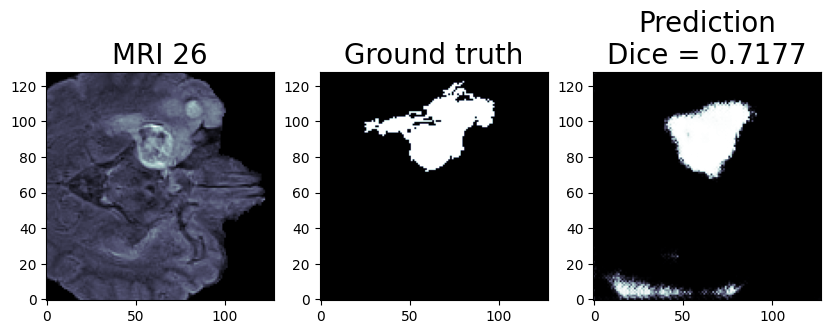

In [20]:
plot_results(ds_test)

# Can we perform inference even faster? Hmm..

Let's find out. Move on the the next tutorial section.

*Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License. SPDX-License-Identifier: EPL-2.0*

*Copyright (c) 2019-2020 Intel Corporation*